<a href="https://colab.research.google.com/github/mayankag23/DeeployCV_230639/blob/main/Deeface_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[140k real & fake images dataset](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces)



The dataset contains 4 files, namely:-


*   `real_vs_fake.tar` (This is the zip that contains all the images)
*  ` train.csv`
* `test.csv`
* `validation.csv`
---
#                        About the Model Implementation

###We exact the real-vs-fake file and then segreate the images in 3 directories:- train, test and validation.
###We did a few operation in this dataset to make it run and work. We first reduced the dataset on which we are training so that more number of epoches can be run with the same computation power and rather than using VGG16 or VGGFace we use **ResNet50** as our model architecture to detect real and fake images.
### We had a dilema regarding using the entire dataset and inturn use less epoches or use more data for training and use less epoches. After evaluations, we decided to use more epoches and less dataset as it was giving us a better result and output.
### We also increased the number of validation images for the training and this decreased the loss to some extend and increased the accuracy slightly
---
# Scope of Improvement
### With more computational power we will be able to detect it better and with more accuracy and avoid the problem of over-fitting with more advanced and powerfull models like VGGFace2 and DenseNet.


##Data Loading and Pre-processing

In [ ]:
import kagglehub
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Path to dataset files:", path)

100%|██████████| 3.75G/3.75G [00:41<00:00, 97.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2'):
 for filename in filenames[:3]:
   print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/test.csv
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/valid.csv
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/train.csv
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/real/50538.jpg
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/real/45064.jpg
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/real/56252.jpg
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake/MM0GHI5TFS.jpg
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake/93Z699ICMO.jpg
/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake/IV8B8SKAL9.jpg
/root

In [ ]:
import cv2
import random
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from tensorflow import keras


from tensorflow.keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers, models

from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


In [ ]:
import os
import random

base_path = '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/'

reduced_train_path = base_path + 'train_reduced/'
reduced_valid_path = base_path + 'valid_reduced/'
reduced_test_path = base_path + 'test_reduced/'

def sample_images(source_dir, target_dir, num_images):
    os.makedirs(target_dir, exist_ok=True)
    for class_name in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_name)
        class_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_target_dir, exist_ok=True)

        images = [os.path.join(class_source_dir, img) for img in os.listdir(class_source_dir) if img.endswith(('.jpg', '.png'))]

        sampled_images = random.sample(images, min(len(images), num_images // len(os.listdir(source_dir))))

        for img in sampled_images:
            shutil.copy(img, class_target_dir)

# Sample 10k images for train, valid, and test (adjust proportionally)
# sample_images(base_path + 'train/', reduced_train_path, 10000)
# sample_images(base_path + 'valid/', reduced_valid_path, 5000)
# sample_images(base_path + 'test/', reduced_test_path, 1000)

image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64

train_flow = image_gen.flow_from_directory(
    reduced_train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

valid_flow = image_gen.flow_from_directory(
    reduced_valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_flow = image_gen.flow_from_directory(
    reduced_test_path,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
print(f'train_flow{train_flow.class_indices}\n valid_flow{valid_flow.class_indices} \n test_flow{test_flow.class_indices}')

train_flow{'fake': 0, 'real': 1}
 valid_flow{'fake': 0, 'real': 1} 
 test_flow{'fake': 0, 'real': 1}


##**ResNet50 Model Deployment**



In [ ]:
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
resnet_model = Model(inputs=resnet_base.input, outputs=x)

resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,146,688 (92.11 MB)

 Trainable params: 24,092,800 (91.91 MB)

 Non-trainable params: 53,888 (210.50 KB)

In [ ]:
resnet_model = Model(inputs=resnet_base.input, outputs=output)
for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


In [ ]:
history = resnet_model.fit(
    train_flow,
    epochs=50,
    validation_data=valid_flow,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 328ms/step - accuracy: 0.5814 - loss: 2.4827 - val_accuracy: 0.6272 - val_loss: 2.2684 - learning_rate: 1.0000e-05
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.5948 - loss: 2.3963 - val_accuracy: 0.6542 - val_loss: 2.1967 - learning_rate: 1.0000e-05
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.5836 - loss: 2.3518 - val_accuracy: 0.6144 - val_loss: 2.1892 - learning_rate: 1.0000e-05
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - accuracy: 0.5819 - loss: 2.3217 - val_accuracy: 0.6570 - val_loss: 2.1094 - learning_rate: 1.0000e-05
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - accuracy: 0.5850 - loss: 2.2783 - val_accuracy: 0.6554 - val_loss: 2.0737 - learning_rate: 1.0000e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 263ms/step - accuracy: 0.5934 - loss: 2.2243 - val_accuracy: 0.6598 - val_loss: 2.0407 - learning_rate: 1.0000e-05
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 30

In [ ]:
test_loss, test_acc = resnet_model.evaluate(test_flow, steps=len(test_flow))
print(f"Test Accuracy: {test_acc:.2f}")

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7049 - loss: 1.4718
Test Accuracy: 0.67


##**Model Accuracy and Evaluation**

In [ ]:

def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

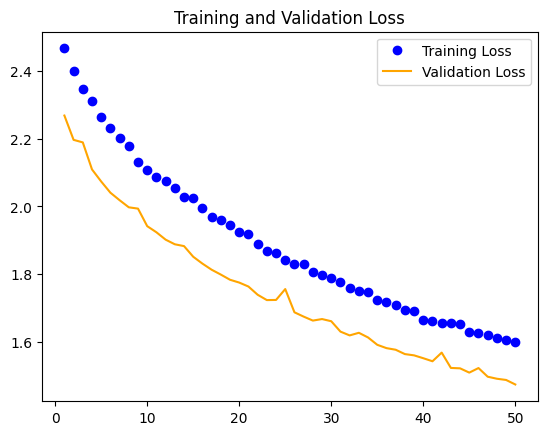

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

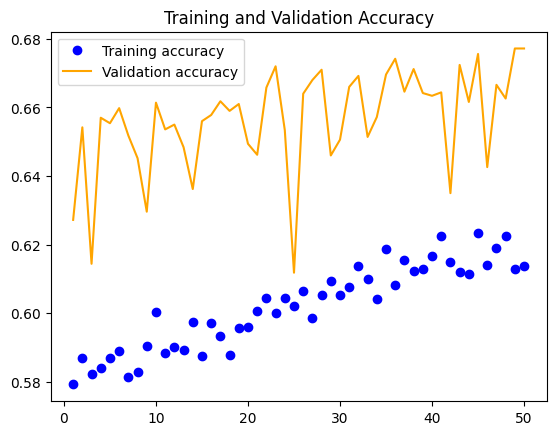

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
y_pred = resnet_model.predict(test_flow)
y_test = test_flow.classes

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.729768
AP Score: 0.7275729728558457

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       500
           1       0.68      0.64      0.66       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



##**Testing and Working out**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The image is fake.


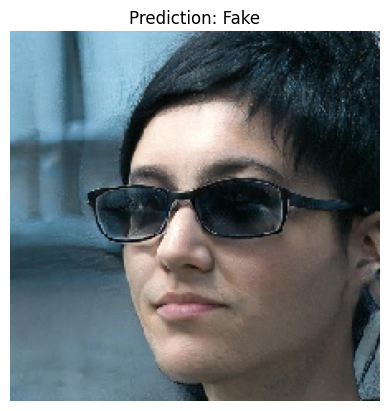

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake/MM0GHI5TFS.jpg'

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = resnet_model.predict(img_array)

# Output the result
if prediction[0] > 0.5:
    print("The image is fake.")
else:
    print("The image is real.")

plt.imshow(img)
plt.title(f"Prediction: {'Fake' if prediction[0] > 0.5 else 'Real'}")
plt.axis('off')
plt.show()


##Saving the model

In [ ]:
import pickle
filename = 'resnet_model.sav'
pickle.dump(resnet_model, open(filename, 'wb'))


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))